# Permutation Importance Documentation

This notebook is designed to demonstrate how to use `mintpy` to compute permutation importance for predictor ranking and plot the results. In this example, two tree-based models (random forest and gradient-boosting) and logistic regression from scikit-learn were trained on road surface temperature data from Handler et al. (2020). The goal is to predict whether road surface temperatures will be above or below freezing (32 F) in the next hour. This dataset has 100 K examples with a class skew of 39%.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import mintpy
import plotting_config 

## Loading the training data and pre-fit models 

In [3]:
model_objs, model_names = mintpy.load_models()
examples, targets = mintpy.load_data()

print(f'Examples Shape : {examples.shape}')
print(f'Target Skew : {targets.mean()*100}%')

Examples Shape : (100000, 30)
Target Skew : 39.173%


# InterpretToolkit

The primary component of `mintpy` is the `InterpretToolkit`, which houses the computations and plotting for all the interpretability method contained within. 

To initialize `InterpretToolkit`, requires: 

* a pre-fit model object (or multiple models) in one of the following formats: 
    * a single pre-fit model object
    * list of pre-fit model objects
    * A dict of model objects with model names as the key
* examples and targets (to evaluate the model on)
    * Can be `pandas.DataFrame` or `numpy.array`. If use an array, however, then you must provide the feature names (`'feature_names'`)

If you pass a list of model objects (as we have done), then you must specify the names of the objects (as strings) using `model_names` (used for plotting purposes).  

In [4]:
myInterpreter = mintpy.InterpretToolkit(model=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

## Permutation Importance

Predictor ranking is often a first step in model interpretability and a popular model-agnostic approach is the permutation importance method. For permutation importance, for each predictor, that predictor's data is permuted (shuffled) and the permuted predictor causing the greatest loss of skill (based on some error metric) is deemed the most important (and each predictor is ranked subsequently). This describes what is known as the single-pass permuation importance method (McGovern et al. 2019; Fig 1. @ https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance for illustration). The more reliable method, however, is the multi-pass permutation method (Lakshmanan et al. 2015, JOAT; see Fig.2 @ the above link) where predictors remained permuted before assessing the second, third, and so on top predictors. `mintpy` uses a stripped-down version of the python package `PermutationImportance` to compute the both single and multipass permutation importance (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). 

`mintpy.permutation_importance` requires the following args:
* `n_vars`, the number of predictor to compute for the multi-pass method
* `evaluation_fn`, the error function used to assess loss of skill.
    * `mintpy` has 3 built-in error metrics for evaluating predictor importance: 
        * Area under the Curve (`'auc'`)
        * Area under the Precision-Recall Curve (`'aupdrc'`)
        * Brier Skill Score (`'bss'`)
        * Mean Square Error (`'mse'`) 
* `nbootstrap`, number of times to repeat the calcuations for confidence intervals
* `subsample`, percentage of the dataset to use (for speedier results)
* `njobs`, number of processor to run the script on 
    * Could be the exact number or percentage of the total available to use (0-1)
   
__Note__: `evaluation_fn` can also be any user-defined function of the form 
`evaluation_fn(targets,predictions)` where a single value is returned. 
However, when using your own function, then you must also set the scoring strategy. If a metric is positively-oriented (a higher value is better), then set `scoring_strategy = "argmin_of_mean"` and if is negatively-oriented-oriented (a lower value is better), then set `scoring_strategy = "argmax_of_mean"`. 


In this example, we want the computing the top 10 predictors for both of our models. We are using AUC as the error metric and performing bootstrapping for confidence intervals (kept small for illustration purposes, but should typically be 100-1000). For larger datasets, multiple models, a large number of top predictors, the multipass permutation importance method can be computationally expensive so we've included a method to `mintpy` to store the results for later use. 

In [5]:
results = myInterpreter.calc_permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='auc', 
                                               nbootstrap=5, 
                                               subsample=0.001,
                                               njobs=16
                                              )

# Save the permutation importance results as a pickle file
myInterpreter.save_results(fname='multipass_importance_auc.pkl',
                          data=results)

Processing Random Forest...
Using 16 of processors to compute importance...
Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of 10...
Starting on the important variable 8 out of 10...
Starting on the important variable 9 out of 10...
Starting on the important variable 10 out of 10...
Processing Gradient Boosting...
Using 16 of processors to compute importance...
Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of

## Re-loading results 

`mintpy` has the built capability of re-loading our results and properly setting `InterpretToolkit` for plotting. To do so, we initialize an empty `InterpretToolkit` and call the `load_results` method. This method is used for loading results for other computations so we need to set the `option='permutation_importance'`. Lastly, since we are re-loading the results we need to give the model names (for plotting purposes). 

In [6]:
myInterpreter = mintpy.InterpretToolkit()

# Save the permutation importance results as a pickle file
myInterpreter.load_results(fnames='multipass_importance.pkl',
                          option='permutation_importance',
                          model_names=model_names
                          )

print(myInterpreter.pi_dict)

Loading results from multipass_importance.pkl...
{'Gradient Boosting': <mintpy.main.PermutationImportance.result.ImportanceResult object at 0x7ffccb0e5240>, 'Logistic Regression': <mintpy.main.PermutationImportance.result.ImportanceResult object at 0x7ffccb0b1f98>, 'Random Forest': <mintpy.main.PermutationImportance.result.ImportanceResult object at 0x7ffccc602ac8>}


## Plotting Single-Pass Permutation Importance 

The first pass of the multipass permutation method produces the single pass results. To plot single-pass results, set `multipass=False`. Single-pass includes the ranking of every single predictors, so for readability, you can set `num_vars_to_plot` (default=15). Lastly, set `metric` equal to plot-friendly version of the error metric used to compute the permutation importance. In this case, we used the area under the curve on the training dataset.  

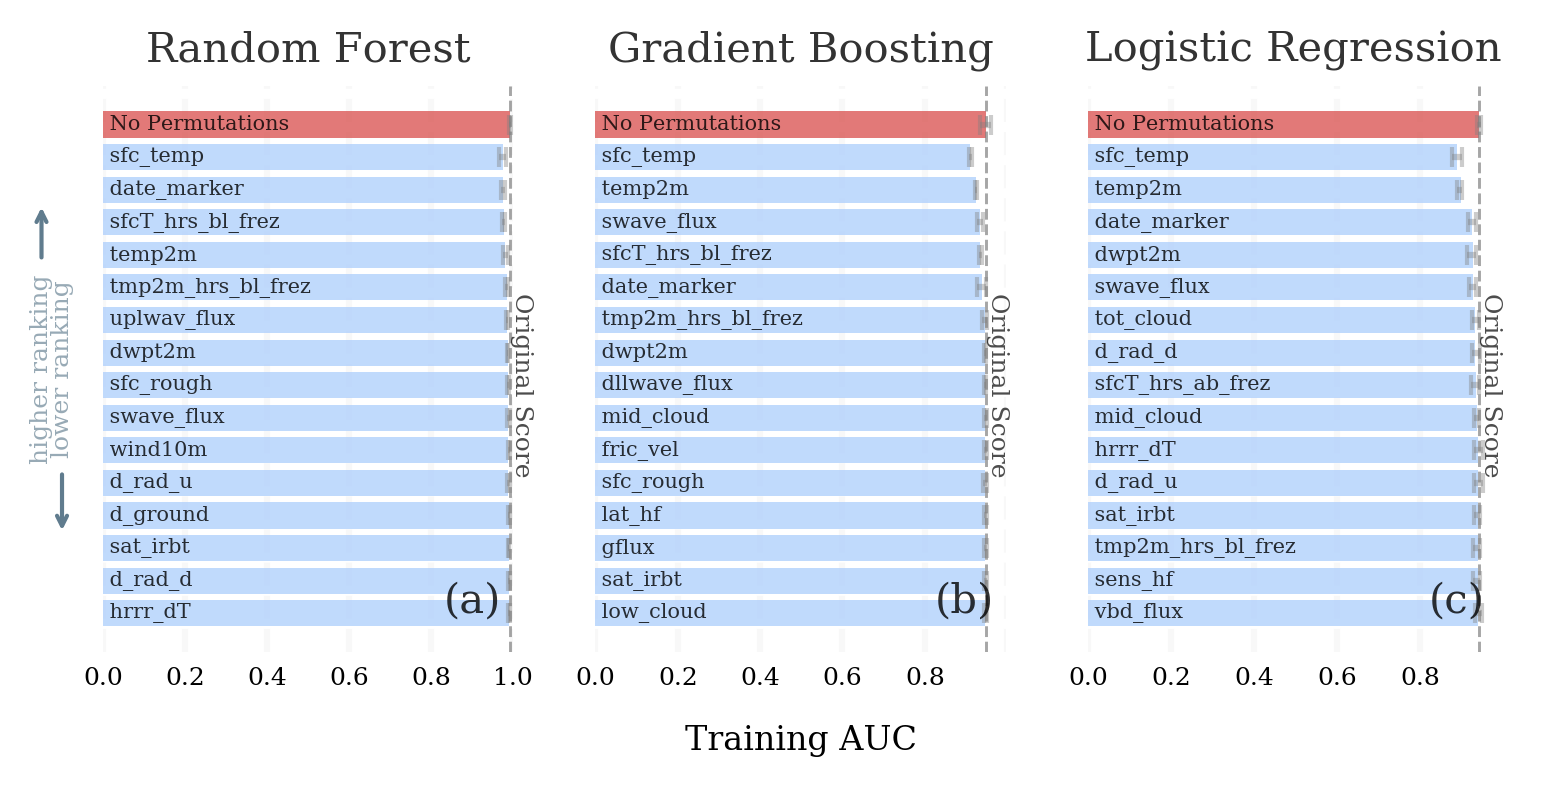

In [7]:
fig = myInterpreter.plot_importance(
                                    multipass=False, 
                                    metric ="Training AUC", 
                                    num_vars_to_plot=15,
                                   )

## Plotting Multi-Pass Permutation Importance 

To plot the multi-pass results, set the `multipass=True`. 


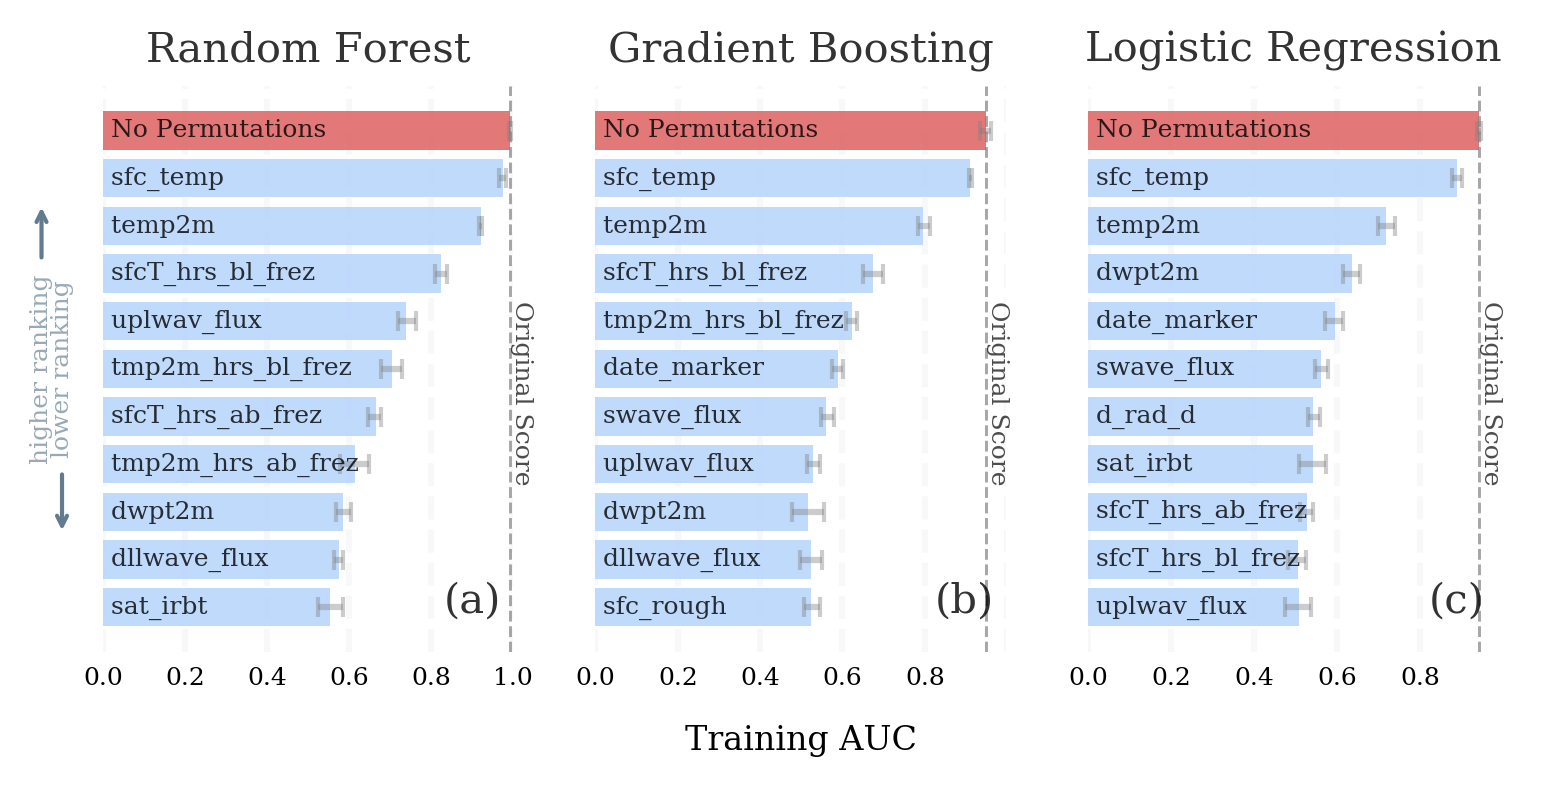

In [8]:
fig = myInterpreter.plot_importance(multipass=True, metric = "Training AUC")

## Plotting Permutation Importance (with Color Coding and Readable Predictor Names)

To personalize your plots, you can pass a dict `readable_feature_names`, which maps the stored predictor name with a prettier, more interpretable name. Additionally, you can color code your predictors with `feature_colors`, which maps the stored feature names to a color (see https://i.stack.imgur.com/nCk6u.jpg for a extension map of named colors in python). To see our example of `readable_feature_names` and `feature_colors`, look in `plotting_config.py`. 

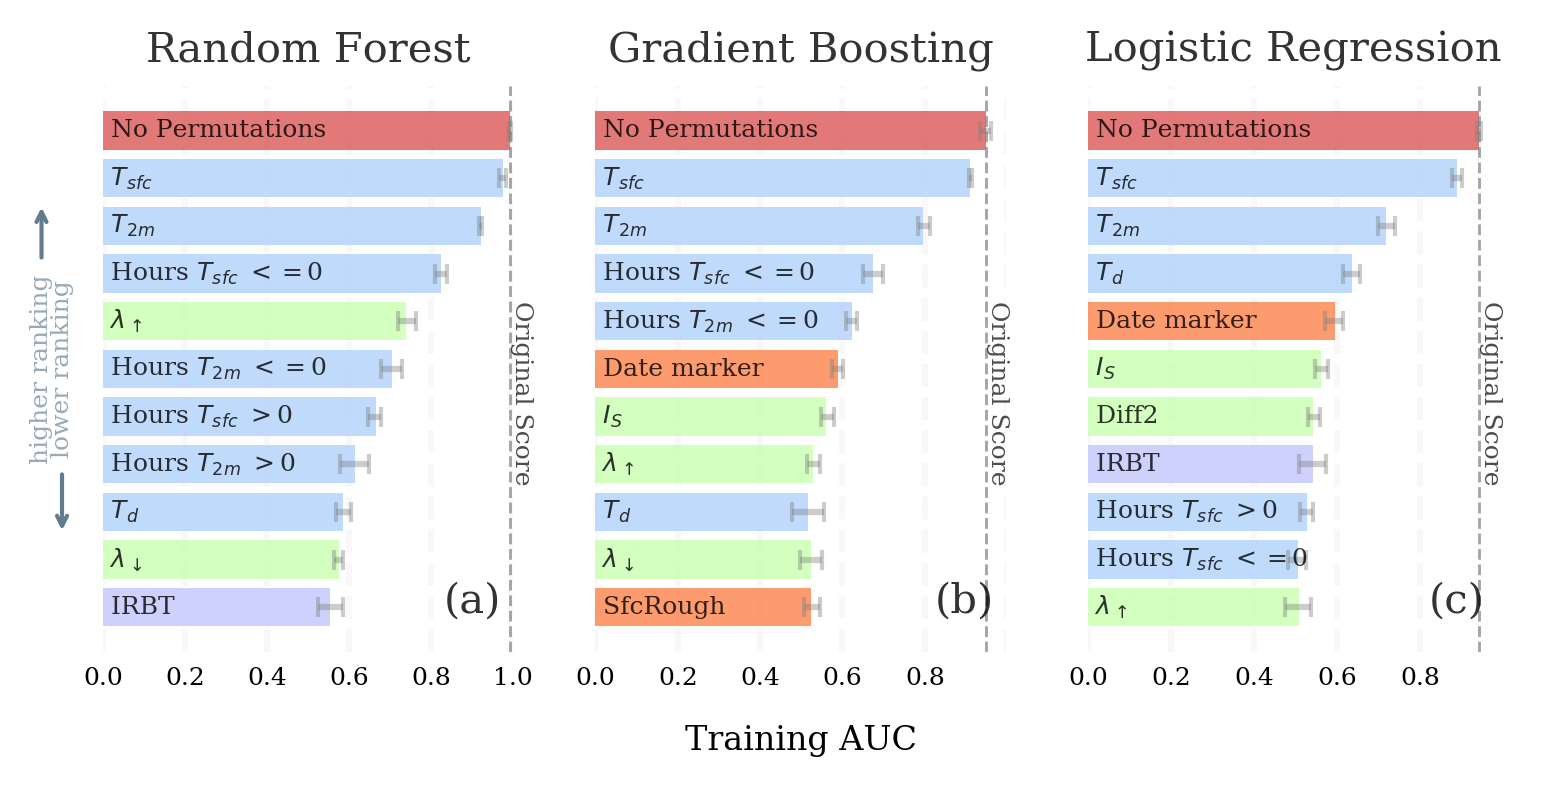

In [9]:
fig = myInterpreter.plot_importance(multipass=True, 
                                    metric = "Training AUC", 
                                    readable_feature_names=plotting_config.readable_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                   )

### Plotting Permutation Importance for Multiple Metrics 

The feature ranking can be sensitive to the error metric used. We can compute the permutation importance again, but this time with Area under the Precision-Recall Curve (AUPRC; also known as Area under the Performance Diagram for meteorologists). To plot results for both metrics, set `result_dict` to a list of both results. Also, to label each row, set the argument `ylabels`. In our case, We've set `ylabels = ['AUC', 'AUPRC']`.

In [10]:
myInterpreter = mintpy.InterpretToolkit(model=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )
auprc_results = myInterpreter.calc_permutation_importance(
                                               n_vars=10, 
                                               evaluation_fn='auprc', 
                                               nbootstrap=5, 
                                               subsample=0.01,
                                               njobs=16
                                              )

Processing Random Forest...
Using 16 of processors to compute importance...
Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of 10...
Starting on the important variable 8 out of 10...
Starting on the important variable 9 out of 10...
Starting on the important variable 10 out of 10...
Processing Gradient Boosting...
Using 16 of processors to compute importance...
Starting on the important variable 1 out of 10...
Starting on the important variable 2 out of 10...
Starting on the important variable 3 out of 10...
Starting on the important variable 4 out of 10...
Starting on the important variable 5 out of 10...
Starting on the important variable 6 out of 10...
Starting on the important variable 7 out of

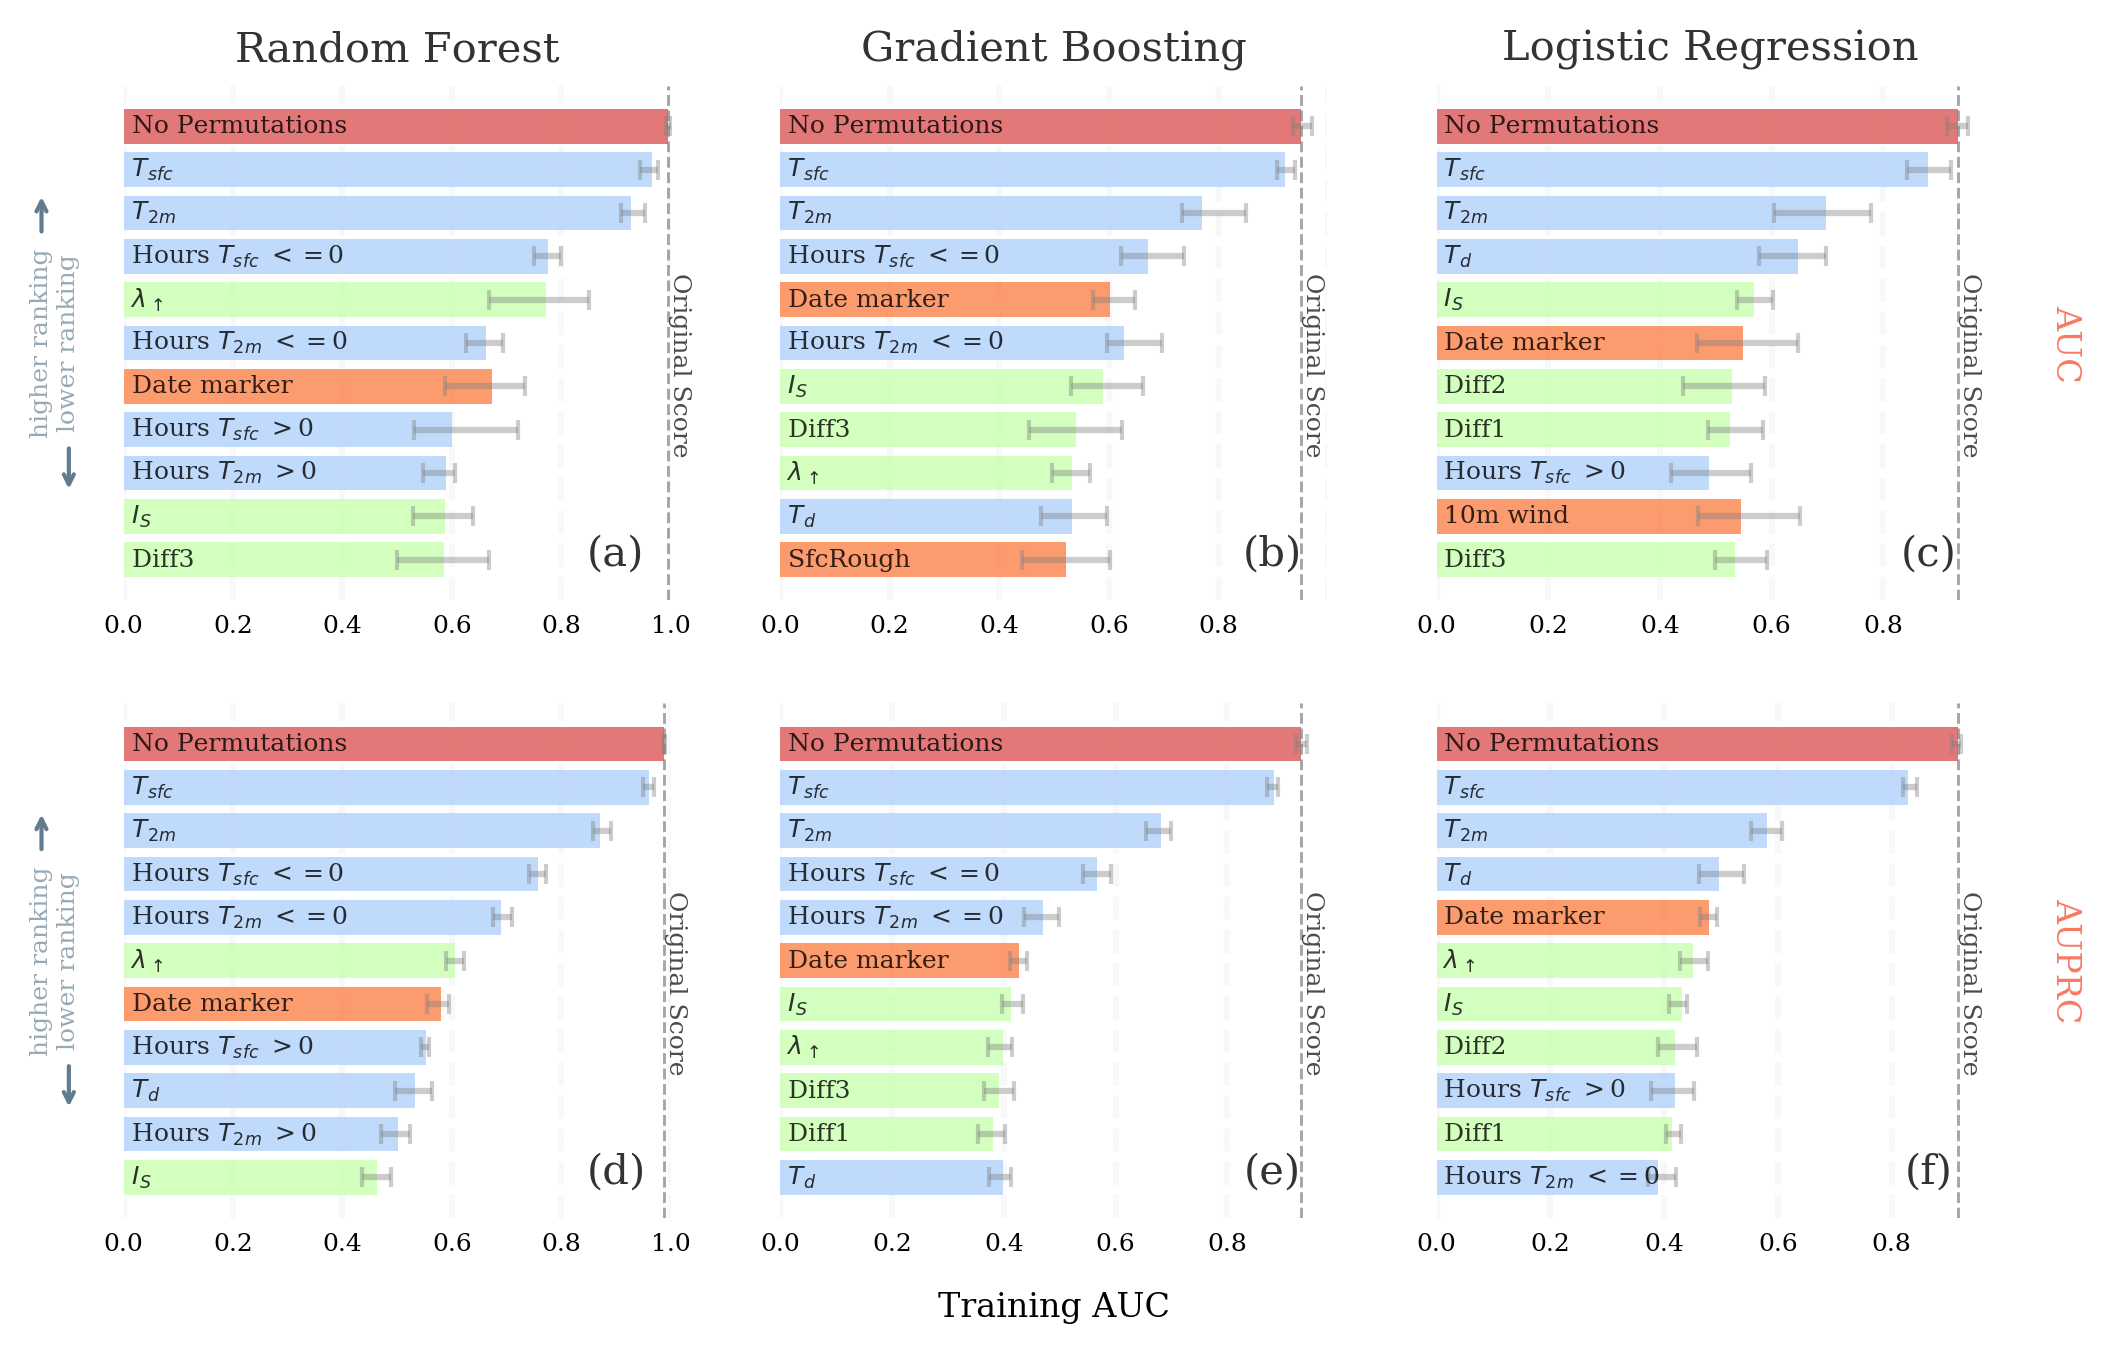

In [11]:
fig = myInterpreter.plot_importance(
                                    result_dict = [results, auprc_results],
                                    multipass=True, 
                                    metric = "Training AUC", 
                                    readable_feature_names=plotting_config.readable_feature_names,
                                    feature_colors=plotting_config.color_dict,
                                    ylabels = ['AUC', 'AUPRC'],
                                    figsize = (8,5), 
                                    hspace = 0.2
                                   )

There are some differences, but overall the feature ranking are roughly similar. This bolsters our confidence in the feature ranking and helps triangulate the most important predictors. 

References: 

Handler, S. L., H. D. Reeves, and A. McGovern, Development of a Probabilistic Subfreezing Road Temperature Nowcast and Forecast Using Machine Learning. Wea. Forecasting, doi: https://doi.org/10.1175/WAF-D-19-0159.1

McGovern, A., R. Lagerquist, D. John Gagne, G. E. Jergensen, K. L. Elmore, C. R. Homeyer, and T. Smith, 2019: Making the Black Box More Transparent: Understanding the Physical Implications of Machine Learning. Bull. Amer. Meteor. Soc., 100, 2175–2199, https://doi.org/10.1175/BAMS-D-18-0195.1.